In [2]:
# Import relevant libraries
import os
import random
import warnings
from itertools import chain
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121, InceptionV3, MobileNetV2, ResNet50, VGG16
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import (BatchNormalization, Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, MaxPooling2D)
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


In [1]:
# Defining paths to the directories on your local machine
healthy_path = r'G:\IIOR\healthy'
diseased_path = r'G:\IIOR\diseased'
image_dir = r'G:\IIOR'




# Create dictionary for categories and paths
categories_paths = {
    'healthy': healthy_path,
    'diseased': diseased_path
    }


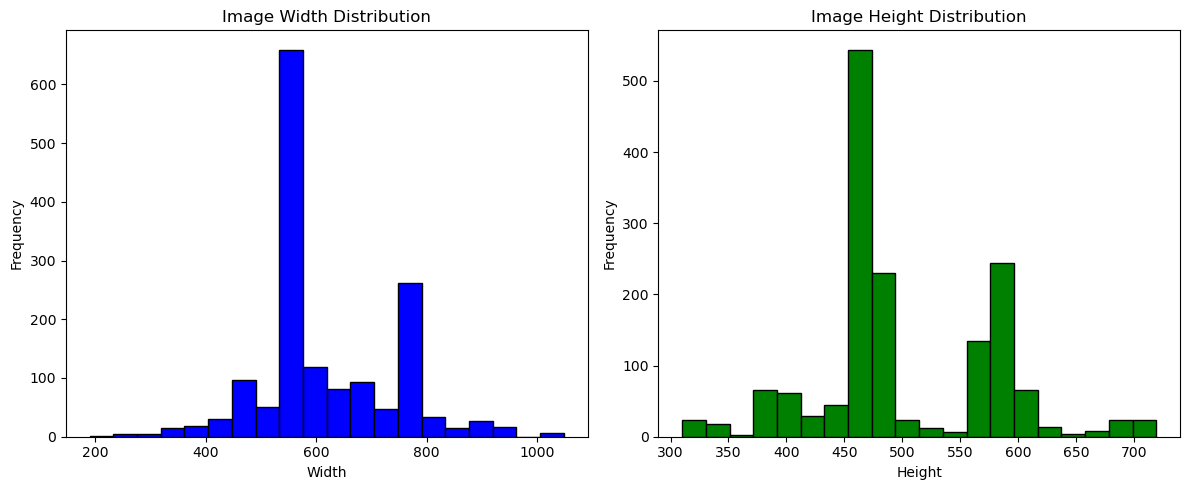

In [8]:
# Initialize lists to store widths and heights
widths = []
heights = []

# Loop over each category and path
for category, path in categories_paths.items():
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        # Read the image in grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # Get the dimensions
        h, w = img.shape
        widths.append(w)
        heights.append(h)

# Plot the Image Size Distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(widths, bins=20, color='blue', edgecolor='black')
axes[0].set_title('Image Width Distribution')
axes[0].set_xlabel('Width')
axes[0].set_ylabel('Frequency')

axes[1].hist(heights, bins=20, color='green', edgecolor='black')
axes[1].set_title('Image Height Distribution')
axes[1].set_xlabel('Height')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Number of images for each class:
Normal: 266 (16.86%)
Benign: 891 (56.46%)
Malignant: 421 (26.68%)


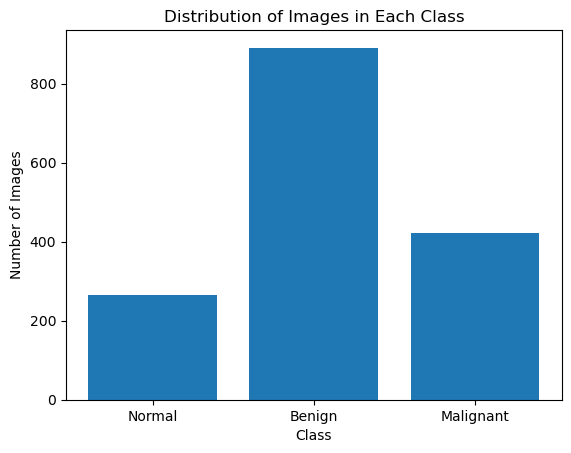

In [11]:
# Get the list of files in each directory
normal_images = os.listdir(normal_path)
benign_images = os.listdir(benign_path)
malignant_images = os.listdir(malignant_path)

# Count the number of images in each class
num_normal_images = len(normal_images)
num_benign_images = len(benign_images)
num_malignant_images = len(malignant_images)

# Calculate percentages
total_images = num_normal_images + num_benign_images + num_malignant_images
percentage_normal = (num_normal_images / total_images) * 100
percentage_benign = (num_benign_images / total_images) * 100
percentage_malignant = (num_malignant_images / total_images) * 100

# Print the counts and percentages
print("Number of images for each class:")
print("Normal:", num_normal_images, f"({percentage_normal:.2f}%)")
print("Benign:", num_benign_images, f"({percentage_benign:.2f}%)")
print("Malignant:", num_malignant_images, f"({percentage_malignant:.2f}%)")

# Plot a bar chart to visualize the distribution
classes = ['Normal', 'Benign', 'Malignant']
counts = [num_normal_images, num_benign_images, num_malignant_images]

plt.bar(classes, counts)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images in Each Class')
plt.show()

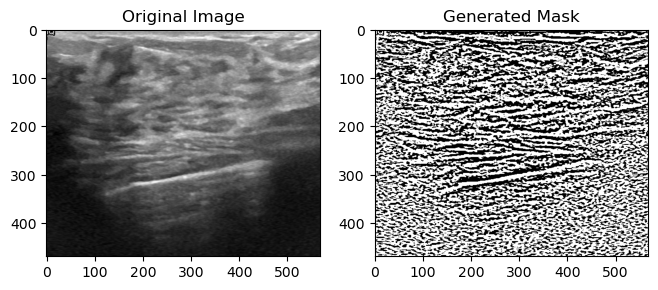

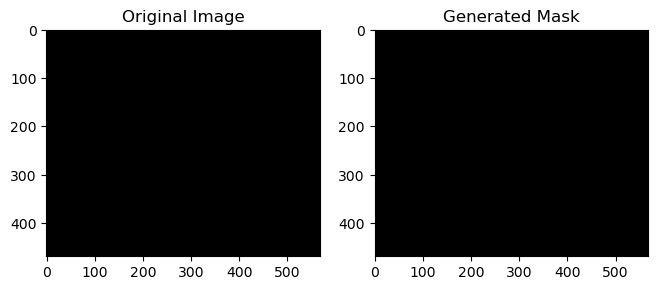

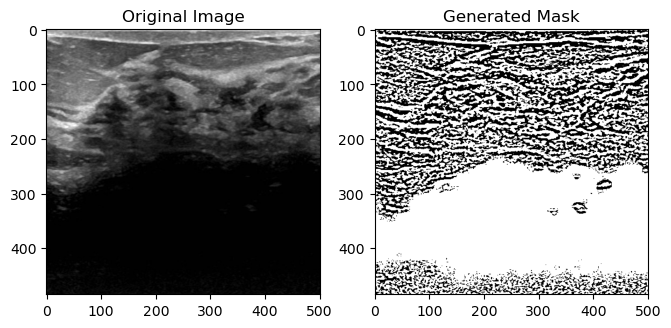

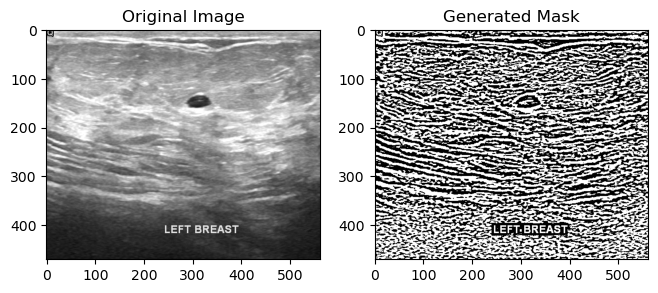

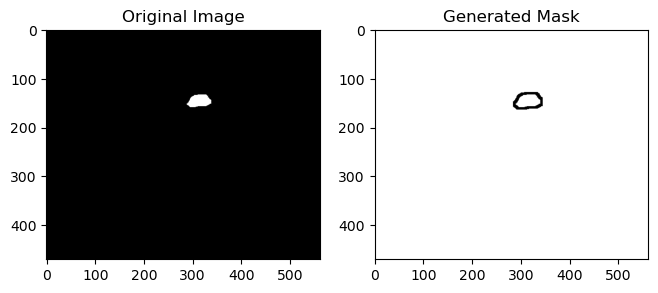

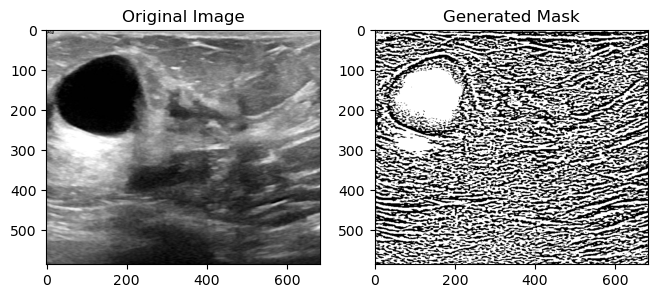

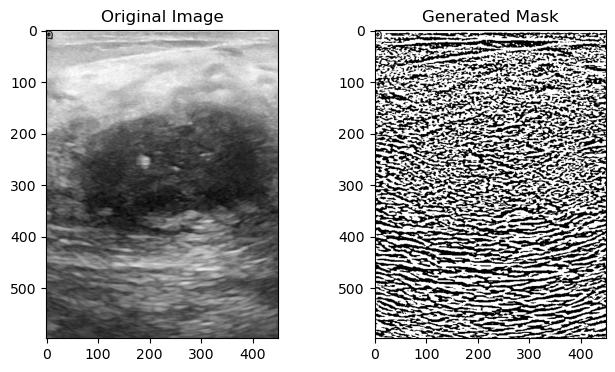

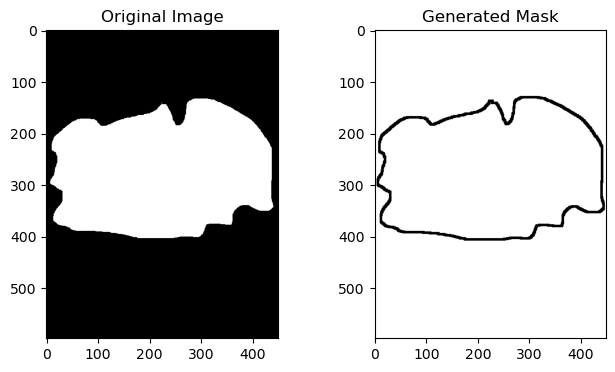

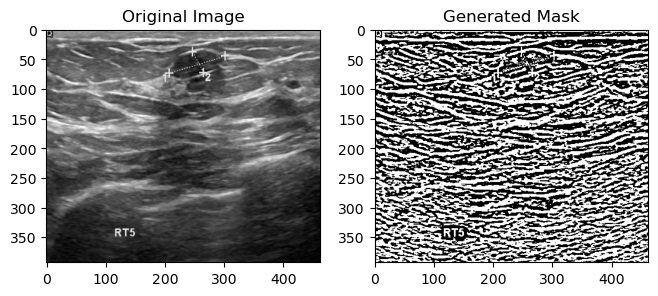

In [14]:
# Define function to apply masks to original images
def apply_masks(images):
    masked_images = []
    for img in images:
        masked_img = cv2.bitwise_and(img, img, mask=img)
        masked_images.append(masked_img)
    return masked_images

def mask_analysis(image_path):
    try:
        # Get image files in the specified path
        image_files = [os.path.join(image_path, f) for f in os.listdir(image_path) if f.endswith('.png')]

        # Load images in grayscale
        images = [cv2.imread(img_f, cv2.IMREAD_GRAYSCALE) for img_f in image_files]

        # Apply adaptive thresholding to isolate cancerous regions
        masks = []
        for img in images:
            mask = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
            masks.append(mask)

            # Set all non-cancerous regions to black
            mask[mask != 255] = 0

        # Display original images and masked images for a sample of three images
        for i in range(3):
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(images[i], cmap='gray')
            plt.title('Original Image')

            plt.subplot(1, 3, 2)
            plt.imshow(masks[i], cmap='gray')
            plt.title('Generated Mask')

            plt.show()
    except Exception as e:
        print(f"Error processing images in {image_path}: {e}")

# Display masks of normal images
mask_analysis(normal_path)
mask_analysis(benign_path)
mask_analysis(malignant_path)

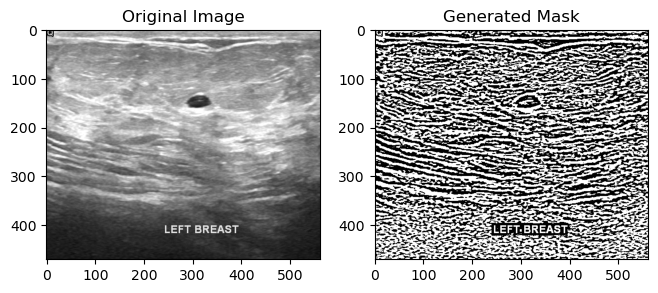

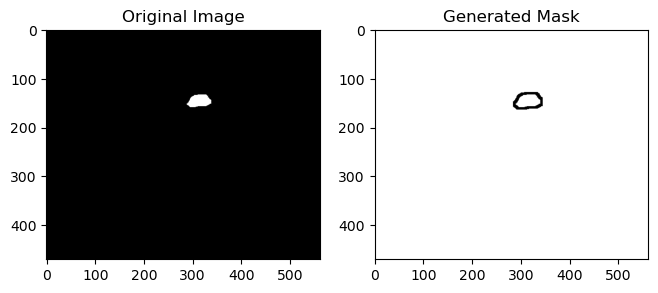

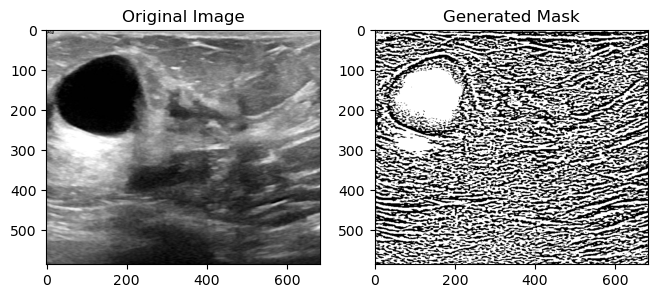

In [15]:
mask_analysis(benign_path)


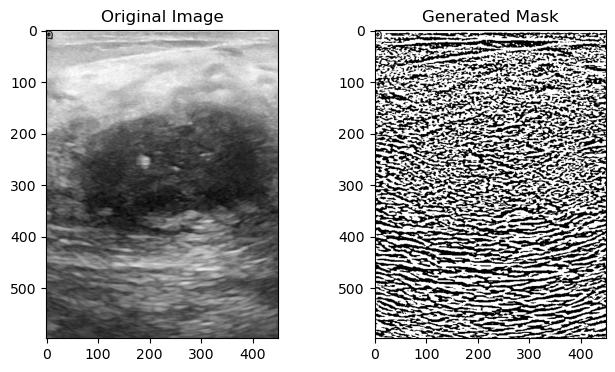

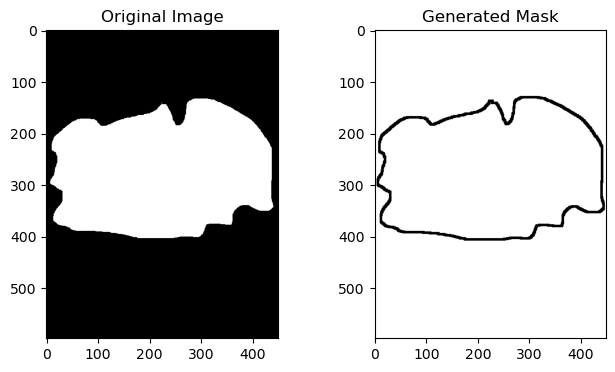

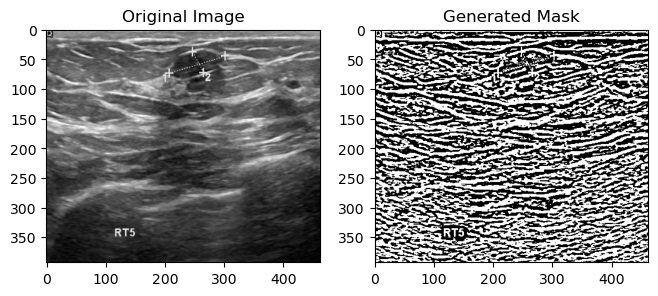

In [16]:
mask_analysis(malignant_path)

Number of images for each class (after balancing):
Normal: 891 (33.33%)
Benign: 891 (33.33%)
Malignant: 891 (33.33%)


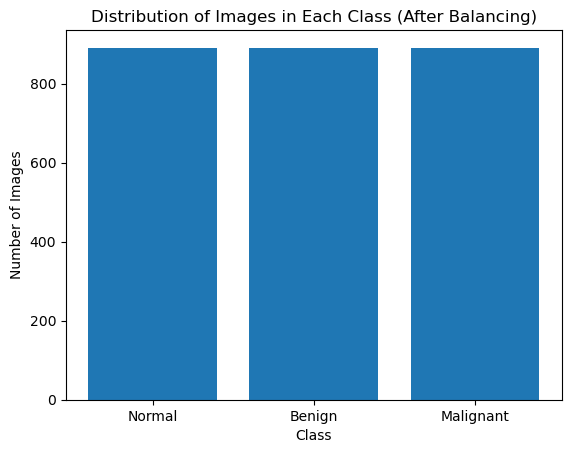

In [18]:
# Calculate the target number of samples for balancing
target_num_samples = max(num_benign_images, num_malignant_images)

# Collecting paths of all .png images from the directories of each class
normal_image_paths = glob.glob(os.path.join(normal_path, '*.png'))
benign_image_paths = glob.glob(os.path.join(benign_path, '*.png'))
malignant_image_paths = glob.glob(os.path.join(malignant_path, '*.png'))

# Oversample the minority classes (Normal and Malignant) with replacement
oversampled_normal_image_paths = random.choices(normal_image_paths, k=target_num_samples)
oversampled_malignant_image_paths = random.choices(malignant_image_paths, k=target_num_samples)

# Update the counts
num_normal_images = len(oversampled_normal_image_paths)
num_malignant_images = len(oversampled_malignant_image_paths)

# Calculate percentages
total_images = num_normal_images + num_benign_images + num_malignant_images
percentage_normal = (num_normal_images / total_images) * 100
percentage_benign = (num_benign_images / total_images) * 100
percentage_malignant = (num_malignant_images / total_images) * 100

# Print the counts and percentages
print("Number of images for each class (after balancing):")
print("Normal:", num_normal_images, f"({percentage_normal:.2f}%)")
print("Benign:", num_benign_images, f"({percentage_benign:.2f}%)")
print("Malignant:", num_malignant_images, f"({percentage_malignant:.2f}%)")

# Plot a bar chart to visualize the distribution
classes = ['Normal', 'Benign', 'Malignant']
counts = [num_normal_images, num_benign_images, num_malignant_images]

plt.bar(classes, counts)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images in Each Class (After Balancing)')
plt.show()

In [19]:
num_normal_images, num_benign_images, num_malignant_images

(891, 891, 891)

In [20]:
# Resize images to 224x224 pixels
img_size = (224, 224)

def load_images(image_paths):
    images = []
    for filepath in image_paths:
        img = Image.open(filepath).convert('L')
        img = img.resize(img_size)
        img_array = np.array(img) / 255.0  # Normalize to [0, 1]
        images.append(img_array)
    return np.array(images)

# Load and process the oversampled images
processed_normal_images = load_images(oversampled_normal_image_paths)
processed_benign_images = load_images(benign_image_paths)
processed_malignant_images = load_images(oversampled_malignant_image_paths)

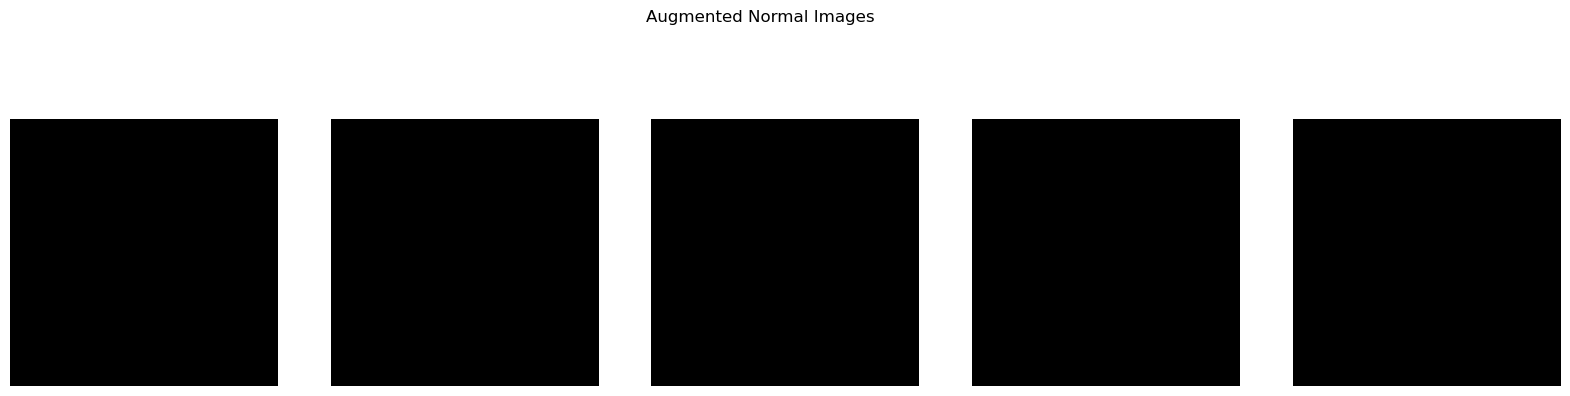

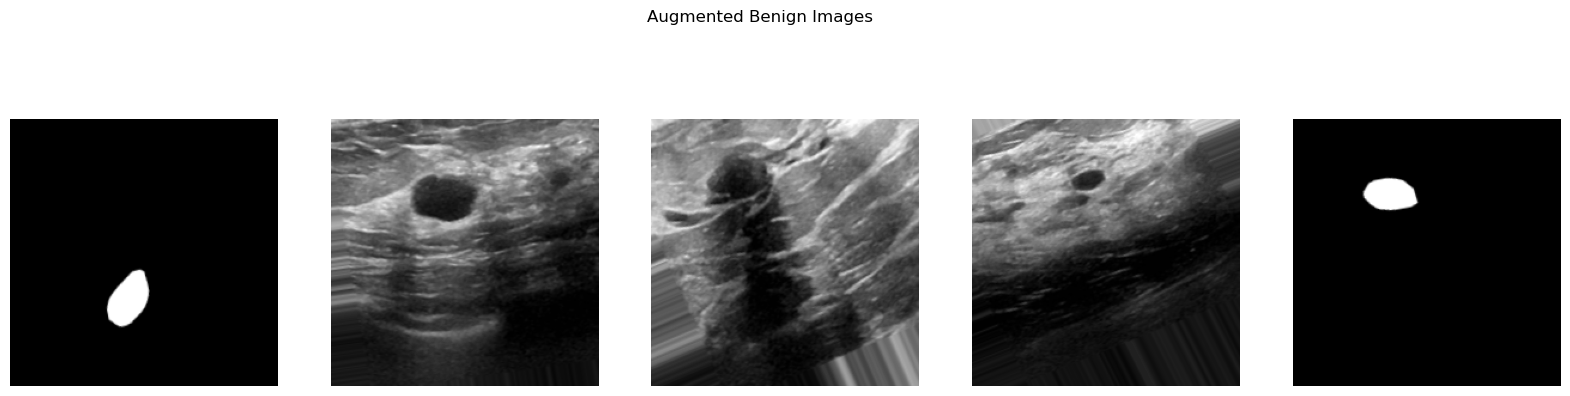

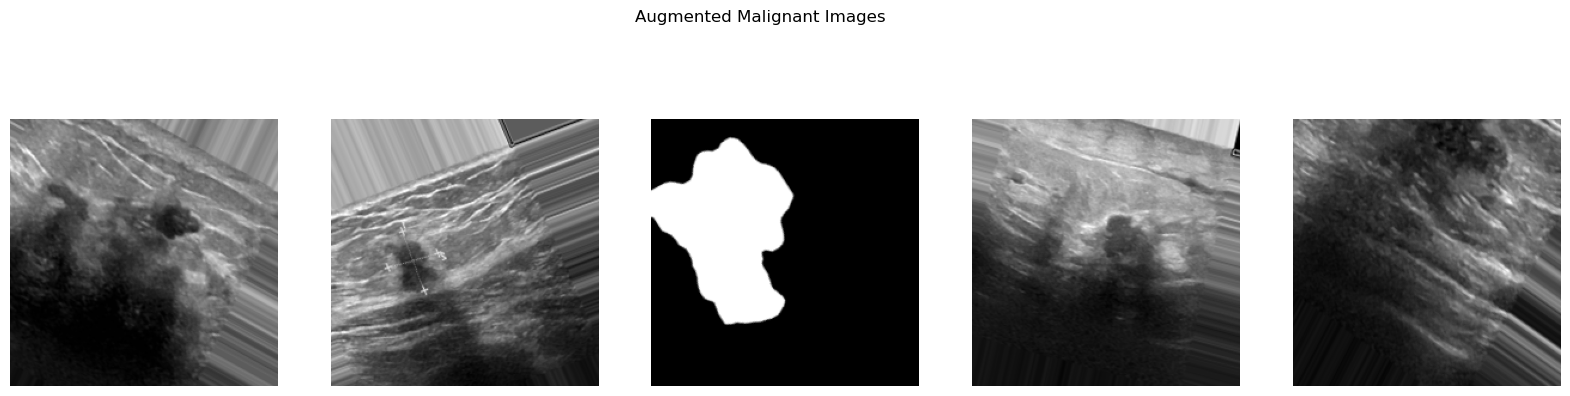

Total number of augmented images across all categories: 26730


In [21]:
# Create a data generator object
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Use the data generator to augment images
def augment_images(images_array, num_augmented_per_image=10):
    reshaped_images = images_array.reshape(images_array.shape[0], 224, 224, 1)
    datagen.fit(reshaped_images)

    augmented_images = []
    for x_batch in datagen.flow(reshaped_images, batch_size=1):
        augmented_images.extend(x_batch)
        if len(augmented_images) >= len(reshaped_images) * num_augmented_per_image:
            break
    return np.array(augmented_images)

# augmented_normal_images = augment_images(processed_normal_images)
# augmented_benign_images = augment_images(processed_benign_images)
augmented_malignant_images = augment_images(processed_malignant_images)

# Visualize some augmented images
def visualize_augmented_images(augmented_images, title):
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    for i in range(5):
        axes[i].imshow(augmented_images[i].reshape(224, 224), cmap='gray')
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

# visualize_augmented_images(augmented_normal_images, "Augmented Normal Images")
# visualize_augmented_images(augmented_benign_images, "Augmented Benign Images")
visualize_augmented_images(augmented_malignant_images, "Augmented Malignant Images")

# Calculate the total number of augmented images across all categories
total_augmented_images = len(augmented_normal_images) + len(augmented_benign_images) + len(augmented_malignant_images)

# Print the total number of augmented images
print(f"Total number of augmented images across all categories: {total_augmented_images}")


In [22]:
# Factor for the number of augmented images generated per original image
augmentation_factor = 10

# Augment images for each class
augmented_normal_images = augment_images(processed_normal_images, num_augmented_per_image=augmentation_factor)
augmented_benign_images = augment_images(processed_benign_images, num_augmented_per_image=augmentation_factor)
augmented_malignant_images = augment_images(processed_malignant_images, num_augmented_per_image=augmentation_factor)

# Create labels: 0 for normal, 1 for benign, 2 for malignant
normal_labels = np.zeros((len(augmented_normal_images),), dtype=int)
benign_labels = np.ones((len(augmented_benign_images),), dtype=int)
malignant_labels = np.full((len(augmented_malignant_images),), 2)

# Concatenate augmented images into a single array 'X' that holds all images
X = np.concatenate([augmented_normal_images, augmented_benign_images, augmented_malignant_images])

# Ensure each image in X has the shape (224, 224)
X_images = [cv2.resize(img, (224, 224)) for img in X]

# Convert list of images back to numpy array
X = np.array(X_images)

# Add channel dimesnion to images
if len(X.shape) == 3:
    X = np.expand_dims(X, axis=-1)

# Combine the separate label arrays into a single array 'y' that holds all the labels
y = np.concatenate([normal_labels, benign_labels, malignant_labels])


In [23]:
# Define the ratios
train_ratio = 0.7
validation_ratio = 0.10
test_ratio = 0.20

# Split the data into a training set and a temporary set for validation and testing
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=1 - train_ratio, random_state=42, stratify=y
)

# Split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=test_ratio, random_state=42, stratify=y_temp
)

# Output the shapes to verify the splits
X_train.shape, X_val.shape, X_test.shape

((18710, 224, 224, 1), (6416, 224, 224, 1), (1604, 224, 224, 1))

In [ ]:
# Model 

In [24]:
# Define the model
baseline_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])

# Compile the model
baseline_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Review the model summary
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 128)               2

In [25]:
# Fit the model
results = baseline_model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=50
)

Epoch 1/50
150/293 [==============>...............] - ETA: 2:57 - loss: 0.9366 - accuracy: 0.5126

KeyboardInterrupt: 

In [ ]:
# Visualize loss and accuracy metrics
training_loss = results.history['loss']
validation_loss = results.history['val_loss']
training_accuracy = results.history['accuracy']
validation_accuracy = results.history['val_accuracy']

# Plot loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Visualize loss and accuracy metrics
training_loss = results.history['loss']
validation_loss = results.history['val_loss']
training_accuracy = results.history['accuracy']
validation_accuracy = results.history['val_accuracy']

# Plot loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()